Imports, run first!

In [111]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from generate_dataset import dat_to_df

Create all four dataframes from .dat files


In [112]:
df_SW = dat_to_df("small_wave/tec.dat","small_wave/mesh.dat")
df_LW = dat_to_df("large_wave/tec.dat","large_wave/mesh.dat")
df_OH = dat_to_df("one_hill/tec.dat","one_hill/mesh.dat")
df_TH = dat_to_df("two_hills/tec.dat","two_hills/mesh.dat")

#df_SW

Method for scaling every column in a dataframe, returns a copy of the dataframe with all variables scaled.

In [113]:
def scale_all(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 
    df_temp = df.copy(deep=True)
    for col in df.columns:
        df_temp[col] = scaler.fit_transform(df[[col]])

    return df_temp    

Apply scaling to the dataframe, in this we create a scaled dataframe as a copy.

In [114]:
df_SW_scaled = scale_all(df_SW)
df_LW_scaled = scale_all(df_LW)
df_OH_scaled = scale_all(df_OH)
df_TH_scaled = scale_all(df_TH)

Correlation matrix for the different variables:

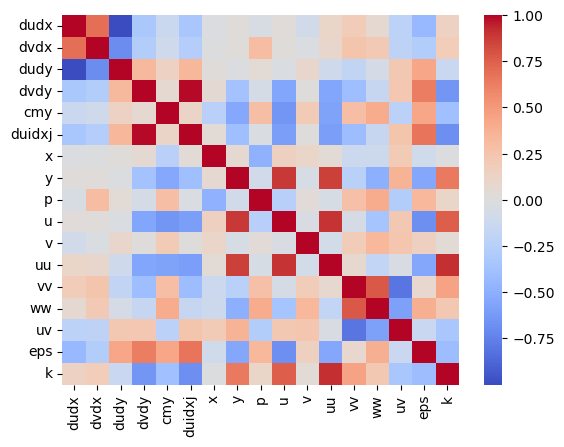

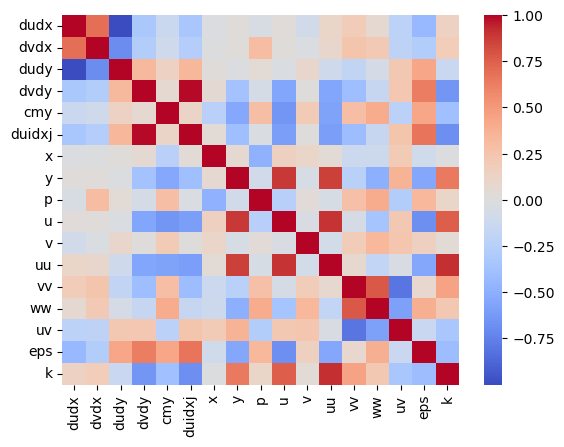

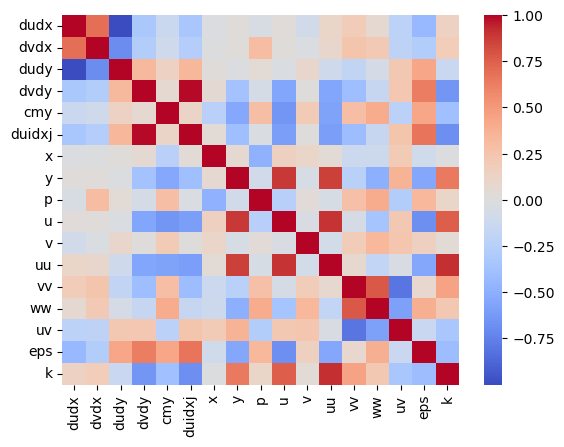

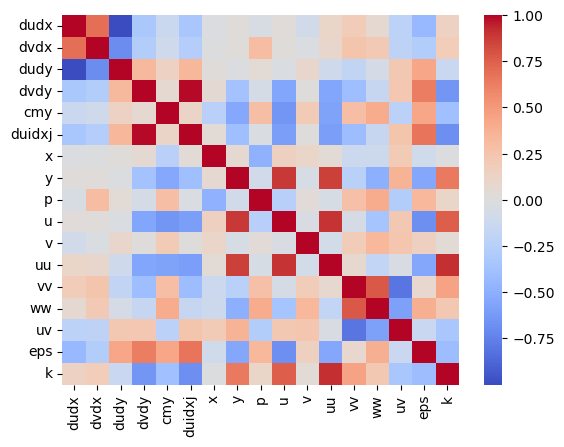

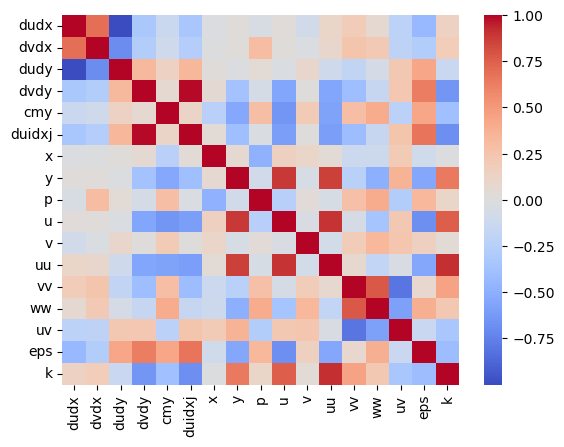

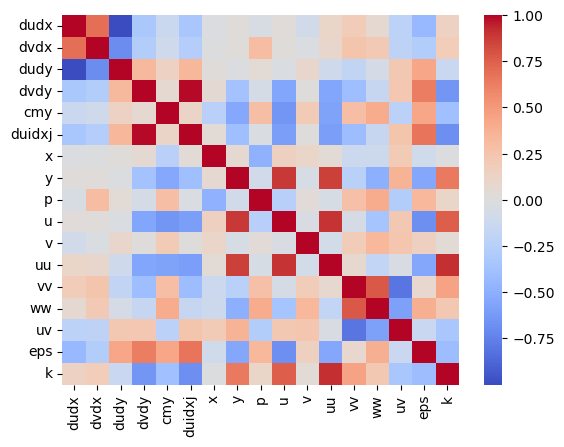

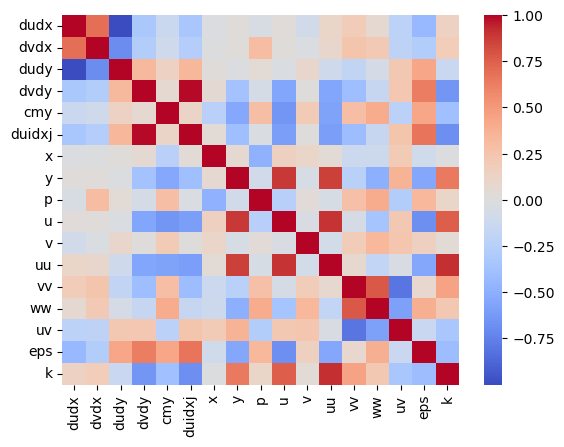

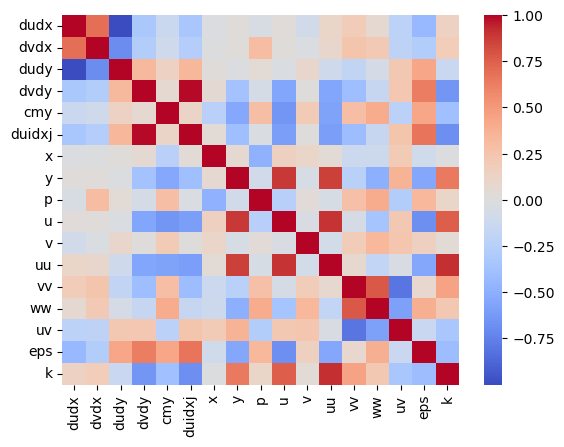

In [115]:
for df in [df_SW,df_LW,df_OH,df_TH,df_SW_scaled,df_LW_scaled,df_OH_scaled,df_TH_scaled]:
    plt.figure()
    sns.heatmap(df_SW.corr(), cmap='coolwarm')
    plt.show()

Set up the machine learning model, in this case we test it on df_SW:


In [116]:
#Set up input/output variable(s)
X=df_SW_scaled[['dudx','dvdx','dudy','dvdy']]
Y=df_SW['cmy'].values

#Split into trainig set and test set:
X_train_SW, X_test_SW, Y_train_SW, Y_test_SW = train_test_split(X, Y, test_size=0.2, random_state=42)

#Choose model and fit it:
model = SVR(kernel='rbf', C=1, epsilon=0.01)
svr_SW = model.fit(X_train_SW, Y_train_SW)

Testing different values for C

100%|██████████| 20/20 [17:35<00:00, 52.76s/it]


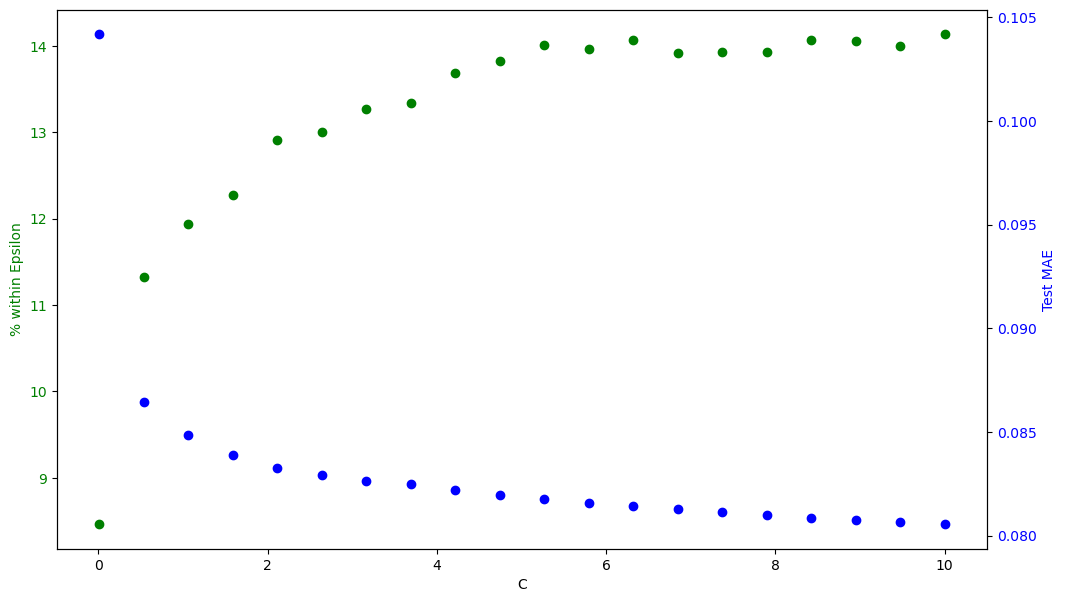

In [117]:
test_mae_list = []    
perc_within_eps_list = []

c_space = np.linspace(0.01, 10, num=20)
eps = 0.01

for c in tqdm(c_space):
    
    varied_svr = SVR(kernel = 'rbf', C=c, epsilon = eps)
    varied_svr.fit(X_train_SW, Y_train_SW)
    
    test_mae = mean_absolute_error(Y_test_SW, varied_svr.predict(X_test_SW))
    test_mae_list.append(test_mae)
    
    perc_within_eps = 100*np.sum(abs(Y_test_SW-varied_svr.predict(X_test_SW)) <= eps) / len(Y_test_SW)
    perc_within_eps_list.append(perc_within_eps)

fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(c_space, perc_within_eps_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(c_space, test_mae_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

Scale the neccecary columns of all dataframes, the scaled columns are added to the original   
dataframe giving a new column 'var_scaled' in addition to the original column 'var' 

In [ ]:

def scale_df(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 

    df['duidxj_scaled'] = scaler.fit_transform(df[['duidxj']])
    df['k_scaled']      = scaler.fit_transform(df[['k']])
    df['uv_scaled']     = scaler.fit_transform(df[['uv']])
    df['eps_scaled']    = scaler.fit_transform(df[['eps']])
    df['p_scaled']      = scaler.fit_transform(df[['p']])
    df['vv_scaled']     = scaler.fit_transform(df[['vv']])
    df['uu_scaled']     = scaler.fit_transform(df[['uu']])
    
    return df